Bike sharing predictions
====================
Predicting number of bike rentals, based on the hourly data of past bike rentals.

Data contains information such as weather, month, day of the week, etc.

Source of data: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [61]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [62]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Columns casual and registered add together to cnt, which we want to predict.  
This data won't be available beforhand and it won't be used in the model

In [63]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


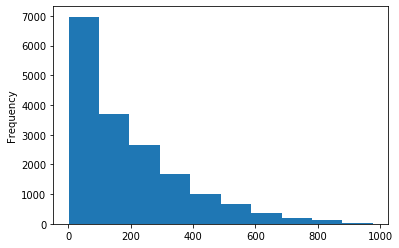

In [64]:
bike_rentals['cnt'].plot.hist(20)

In [65]:
bike_rentals.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Grouping the hours to time of the day (night, morning, afternoon, evening) can be usefull.  
We will use this for linear model, but not for others, as trees already will split the hours.

In [66]:
def assign_label(hour):
    if hour <= 6:
        return 4
    elif hour<= 12:
        return 1
    elif hour <= 18:
        return 2
    else:
        return 3
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

Splitting the data into train and test

In [67]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)].copy()

Picking initial columns

In [68]:
cols = ['yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'atemp', 'hum', 'windspeed', 'time_label']

Building simple linear model and using rmse for the error metric.

In [69]:
model = LinearRegression()
model.fit(train[cols], train['cnt'])
pr = model.predict(test[cols])
mse = mean_squared_error(test['cnt'], pr)
rmse = mse ** (1/2)
rmse

135.25936182474493

In [70]:
print(bike_rentals['cnt'].mean())
print(bike_rentals['cnt'].std())

189.46308763450142
181.38759909186527


Linear model error is less than the standard deviation.  
Still the error is quite big in comparison to the mean.

For trees we use he 'hr' column as mentioned before.

In [71]:
cols = ['yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'atemp', 'hum', 'windspeed', 'hr']

Building simple decision tree with the same predictor columns as in the linear.

In [72]:
tree = DecisionTreeRegressor(max_depth=11, min_samples_leaf=10)
tree.fit(train[cols], train['cnt'])
pr_tree = tree.predict(test[cols])
mse_tree = mean_squared_error(test['cnt'], pr_tree)
rmse_tree = mse_tree ** (1/2)
rmse_tree

66.4020534857684

Building simple random forest with the same predictor columns as in the linear.

In [73]:
forest = RandomForestRegressor(min_samples_leaf=6, max_features=6)
forest.fit(train[cols], train['cnt'])
pr_forest = forest.predict(test[cols])
mse_forest = mean_squared_error(test['cnt'], pr_forest)
rmse_forest = mse_forest ** (1/2)
rmse_forest

54.26626415003175

The decision tree model is much better than linear and random forest even more so.

The estimated errors are small in comparison to the mean and standard deviation.

---

Let's try to combine linear model with a decision tree.

We will first make a tree, but won't split it as deep as before (min_samples_leaf is twice as big).

Then for each leaf we calculate an individual linear model.  
This means if we get 100 leafs from the tree, we will have 100 linear models.

In [74]:
lm_tree = DecisionTreeRegressor(min_samples_leaf=20)
lm_tree.fit(train[cols], train['cnt'])

##determine the leaf_nr for train with the apply method
leaf_nr = lm_tree.apply(train[cols])
train['leaf_nr'] = leaf_nr
##determine the leaf_nr for test
leaf_nr = lm_tree.apply(test[cols])
test['leaf_nr'] = leaf_nr

In [75]:
##build linear models for each leaf
lrs = {}
for i in train['leaf_nr'].unique():
    subset = train[train['leaf_nr']==i].copy()
    lr = LinearRegression()
    lr.fit(subset[cols], subset['cnt'])
    lrs[i] = lr

##predict each leaf
lr_mses = []
lr_rmses = []
lr_weights = []
for i in test['leaf_nr'].unique():
    subset = test[test['leaf_nr']==i].copy()
    pr = lrs[i].predict(subset[cols])
    mse = mean_squared_error(subset['cnt'], pr)
    rmse = mse ** (1/2)
    weight = len(subset)/len(test)
    lr_mses.append(mse)
    lr_rmses.append(rmse)
    lr_weights.append(weight)
lr_mse = np.sum([lr_mses[x] * lr_weights[x] for x in range(0,len(lr_weights))])
lr_rmse = np.sum([lr_rmses[x] * lr_weights[x] for x in range(0,len(lr_weights))])


In [76]:
lr_rmse

47.66162032858389

The error is even lower than for random forest.